<a href="https://colab.research.google.com/github/fatch01/MalatyaBeylerderesiDam/blob/main/MalatyaBeylerderesiDam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Google Drive bağlantısı için gerekli kütüphane
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Görüntü Temizleme ve İyileştirme**

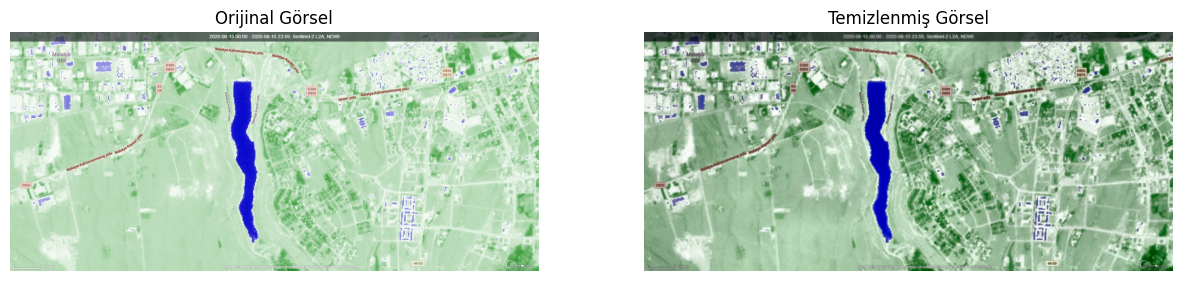

In [ ]:
# Görseli yükleme
image_path =  "/content/private.jpg"  # Görsel yolunu buraya yazın
image = cv2.imread(image_path)

# Görseli RGB formatına çevirme
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Gürültü azaltma (Gaussian Blur ile)
denoised_image = cv2.GaussianBlur(image_rgb, (5, 5), 0)

# Görselin kontrastını artırma (Histogram Eşitleme)
lab_image = cv2.cvtColor(denoised_image, cv2.COLOR_RGB2LAB)
l, a, b = cv2.split(lab_image)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
l_clahe = clahe.apply(l)
enhanced_lab_image = cv2.merge((l_clahe, a, b))
enhanced_image = cv2.cvtColor(enhanced_lab_image, cv2.COLOR_LAB2RGB)

# Sonuçları görselleştirme
plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.title("Orijinal Görsel")
plt.imshow(image_rgb)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Temizlenmiş Görsel")
plt.imshow(enhanced_image)
plt.axis('off')

plt.show()

# **Geometrik Şekil ile Barajın Belirlenmesi**

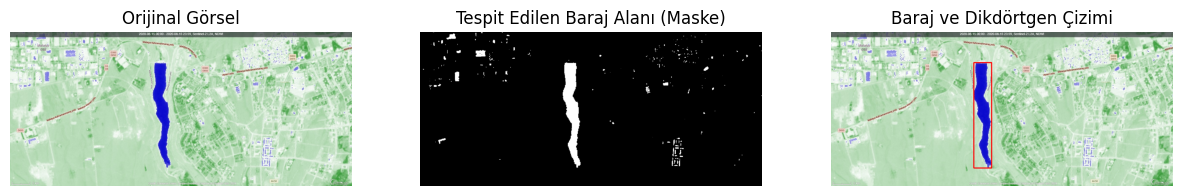

In [ ]:
# Görseli yükleme
image_path = "/content/private.jpg"  # Görsel yolunu güncelleyin
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Mavi renk tonlarını tespit etmek için HSV formatına geçiş
image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Mavi renk aralığı (NDWI verisindeki baraj rengi)
lower_blue = np.array([100, 50, 50])
upper_blue = np.array([140, 255, 255])

# Maske oluşturma
mask = cv2.inRange(image_hsv, lower_blue, upper_blue)

# Maske ile görüntüyü birleştirme
result = cv2.bitwise_and(image_rgb, image_rgb, mask=mask)

# Baraj alanını bulma (kontur tespiti)
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
largest_contour = max(contours, key=cv2.contourArea)

# Geometrik şekil (dikdörtgen) çizimi
x, y, w, h = cv2.boundingRect(largest_contour)
output_image = image_rgb.copy()
cv2.rectangle(output_image, (x, y), (x + w, y + h), (255, 0, 0), 3)

# Sonuçları görselleştirme
plt.figure(figsize=(15, 10))
plt.subplot(1, 3, 1)
plt.title("Orijinal Görsel")
plt.imshow(image_rgb)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Tespit Edilen Baraj Alanı (Maske)")
plt.imshow(mask, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Baraj ve Dikdörtgen Çizimi")
plt.imshow(output_image)
plt.axis('off')

plt.show()


# **Model Eğitimi**

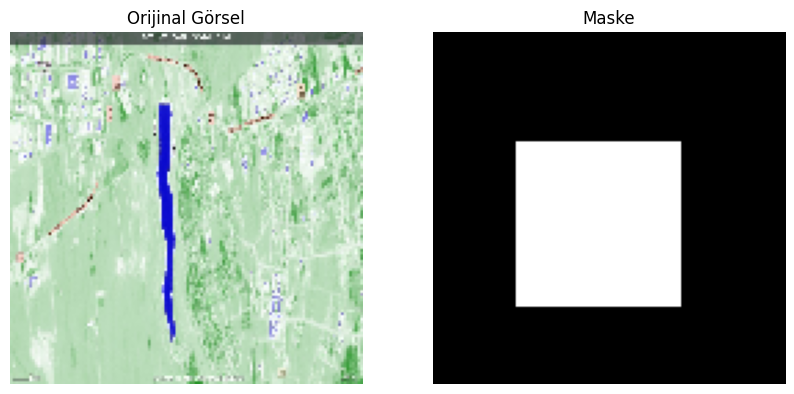

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 54s 7s/step - accuracy: 0.6253 - loss: 0.6355
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 49s 7s/step - accuracy: 0.7684 - loss: 0.5409
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 51s 7s/step - accuracy: 0.7640 - loss: 0.5434
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 84s 8s/step - accuracy: 0.7761 - loss: 0.5475
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 80s 7s/step - accuracy: 0.7824 - loss: 0.5385
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 80s 7s/step - accuracy: 0.7780 - loss: 0.5155
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 57s 8s/step - accuracy: 0.7929 - loss: 0.4612
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 76s 7s/step - accuracy: 0.8125 - loss: 0.4252
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 49s 7s/step - accuracy: 0.8139 - loss: 0.3807
Epoch 10/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 82s 7s/step - accuracy: 0.8190 - loss: 0.3616
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step


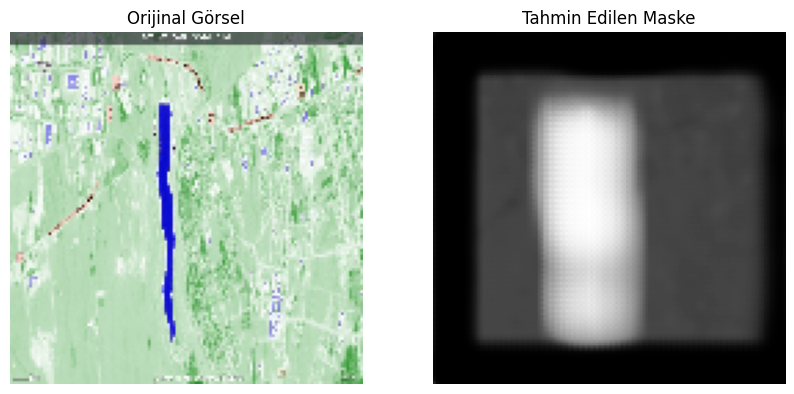

In [ ]:
# U-Net modelini oluşturma
def unet_model(input_shape):
    inputs = tf.keras.Input(input_shape)

    # Encoder (Downsampling)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    # Bottleneck
    c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c5)

    # Decoder (Upsampling)
    u6 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c2])
    c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c1])
    c7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c7)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c7)

    model = Model(inputs, outputs)
    return model

# Görseli yükleme
image_path ="/content/private.jpg" # Görsel yolu
image = tf.keras.preprocessing.image.load_img(image_path, target_size=(128, 128))
image = tf.keras.preprocessing.image.img_to_array(image) / 255.0

# El ile maske oluşturma (örnek olarak)
mask = np.zeros((128, 128, 1))
mask[40:100, 30:90, :] = 1  # Su kütlesi için rastgele bir alan

# Görsel ve maskeyi görselleştirme
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Orijinal Görsel")
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Maske")
plt.imshow(mask[:, :, 0], cmap='gray')
plt.axis('off')
plt.show()

# Veri artırma (Data Augmentation)
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Görsel ve maskeyi genişletme
augmented_images = []
augmented_masks = []

for i in range(50):  # 50 adet veri artırılmış örnek üret
    augmented = next(datagen.flow(np.expand_dims(image, 0), batch_size=1))
    augmented_mask = next(datagen.flow(np.expand_dims(mask, 0), batch_size=1))
    augmented_images.append(augmented[0])
    augmented_masks.append(augmented_mask[0])

augmented_images = np.array(augmented_images)
augmented_masks = np.array(augmented_masks)

# Modeli tanımlama ve derleme
input_shape = (128, 128, 3)
model = unet_model(input_shape)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Modeli eğitme
history = model.fit(augmented_images, augmented_masks, batch_size=8, epochs=10)

# Görselleri test etme
test_image = np.expand_dims(image, axis=0)  # Test için orijinal görseli kullan
predicted_mask = model.predict(test_image)

# Sonucu görselleştirme
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Orijinal Görsel")
plt.imshow(test_image[0])
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Tahmin Edilen Maske")
plt.imshow(predicted_mask[0, :, :, 0], cmap='gray')
plt.axis('off')

plt.show()

# **Maskeleme İşlemi**

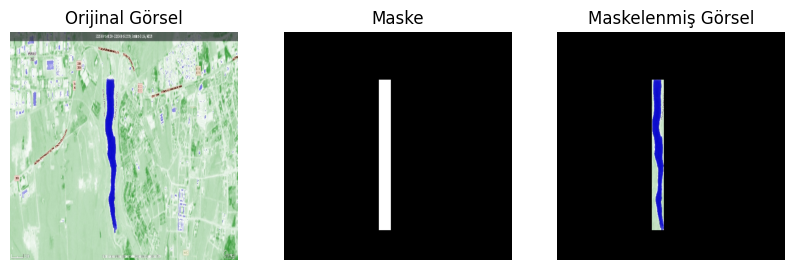

True

In [ ]:
# Görseli yükleme
image_path = "/content/private.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Görseli RGB formatına çevir
image_resized = cv2.resize(image, (512, 512))  # Görsel boyutunu küçült

# Su kütlesi için dikdörtgen ROI seçimi
x1, y1, x2, y2 = 213, 107, 240, 445  # Dikdörtgenin köşe koordinatları

# Maskeleme işlemi
mask = np.zeros_like(image_resized[:, :, 0])  # Siyah bir maske oluştur
mask[y1:y2, x1:x2] = 255  # Belirtilen ROI bölgesini beyaz yap

masked_image = cv2.bitwise_and(image_resized, image_resized, mask=mask)  # Görseli maskele

# Maske ve görseli görselleştirme
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.title("Orijinal Görsel")
plt.imshow(image_resized)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Maske")
plt.imshow(mask, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Maskelenmiş Görsel")
plt.imshow(masked_image)
plt.axis("off")

plt.show()

# Maskelenmiş görseli kaydetme
cv2.imwrite("masked_image.jpg", cv2.cvtColor(masked_image, cv2.COLOR_RGB2BGR))
cv2.imwrite("mask.jpg", mask)


# **U-Net ile Su Tespiti**

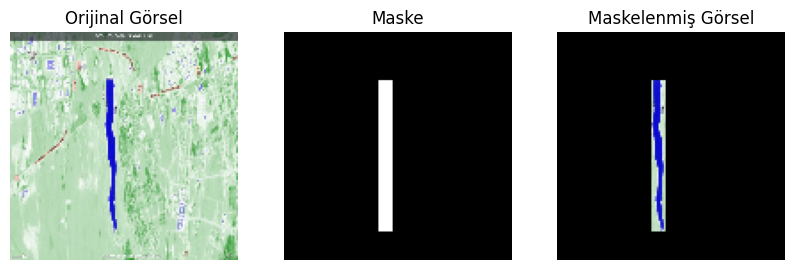

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 62s 8s/step - accuracy: 0.9515 - loss: 0.5173
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 76s 7s/step - accuracy: 0.9504 - loss: 0.2340
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 82s 7s/step - accuracy: 0.9516 - loss: 0.1989
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 79s 7s/step - accuracy: 0.9513 - loss: 0.1878
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 82s 7s/step - accuracy: 0.9512 - loss: 0.1827
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 51s 7s/step - accuracy: 0.9520 - loss: 0.1781
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 51s 7s/step - accuracy: 0.9527 - loss: 0.1724
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 52s 7s/step - accuracy: 0.9510 - loss: 0.1727
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 79s 7s/step - accuracy: 0.9518 - loss: 0.1700
Epoch 10/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 82s 7s/step - accuracy: 0.9518 - loss: 0.1816
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step


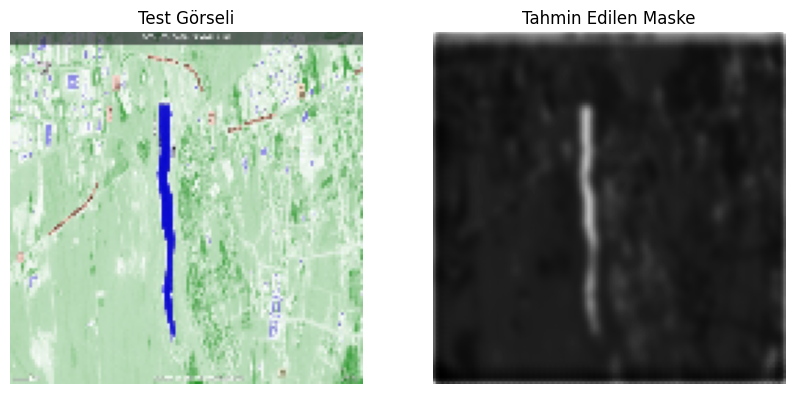

In [ ]:
# U-Net modeli oluşturma
def unet_model(input_shape):
    inputs = tf.keras.Input(input_shape)

    # Encoder (Downsampling)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    # Bottleneck
    c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c5)

    # Decoder (Upsampling)
    u6 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c2])
    c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c1])
    c7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c7)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c7)

    model = Model(inputs, outputs)
    return model

# Görseli yükleme ve yeniden boyutlandırma
image_path = "/content/private.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_resized = cv2.resize(image, (128, 128))  # Model için yeniden boyutlandır

# Dikdörtgen ROI ile maske oluşturma
x1, y1, x2, y2 = 53, 27, 61, 112  # Dikdörtgen koordinatları
mask = np.zeros((128, 128), dtype=np.uint8)  # Siyah bir maske oluştur
mask[y1:y2, x1:x2] = 255  # ROI alanını beyaz yap

# Maskeyi görselleştirme
masked_image = cv2.bitwise_and(image_resized, image_resized, mask=mask)
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.title("Orijinal Görsel")
plt.imshow(image_resized)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Maske")
plt.imshow(mask, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Maskelenmiş Görsel")
plt.imshow(masked_image)
plt.axis("off")
plt.show()

# Veri artırma (Data Augmentation)
image = image_resized / 255.0  # Normalizasyon
mask = mask / 255.0  # Maskeyi normalize et
image = np.expand_dims(image, axis=0)  # Batch boyutunu ekle
mask = np.expand_dims(mask, axis=-1)  # Kanal boyutunu ekle

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

augmented_images = []
augmented_masks = []

for i in range(50):  # 50 veri artırılmış örnek üret
    augmented_image = next(datagen.flow(image, batch_size=1))[0]
    augmented_mask = next(datagen.flow(np.expand_dims(mask, 0), batch_size=1))[0]
    augmented_images.append(augmented_image)
    augmented_masks.append(augmented_mask)

augmented_images = np.array(augmented_images)
augmented_masks = np.array(augmented_masks)

# Modeli tanımlama ve derleme
input_shape = (128, 128, 3)
model = unet_model(input_shape)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Modeli eğitme
history = model.fit(augmented_images, augmented_masks, batch_size=8, epochs=10)

# Test için tahmin
test_image = np.expand_dims(image[0], axis=0)
predicted_mask = model.predict(test_image)

# Tahmin edilen maskeyi görselleştirme
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Test Görseli")
plt.imshow(test_image[0])
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Tahmin Edilen Maske")
plt.imshow(predicted_mask[0, :, :, 0], cmap='gray')
plt.axis('off')
plt.show()

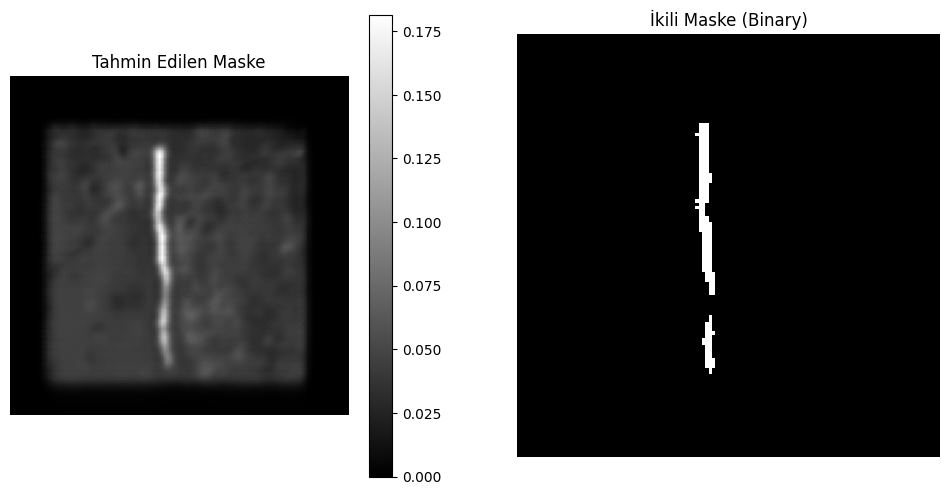

Tahmin edilen toplam su alanı: 19500.00 m²
Tahmin edilen toplam su alanı: 0.0195 km²


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Piksel başına alan (örnek değer, Sentinel-2'ye göre m² cinsinden ayarlanabilir)
pixel_area = 10 * 10  # Sentinel-2 piksel boyutu 10m x 10m (100 m²)

# Eşik değerine göre ikili maske oluşturma
threshold = 0.1  # Tahmin edilen maskeye göre eşik değerini ayarlayın
predicted_mask_binary = (predicted_mask[0, :, :, 0] > threshold).astype(np.uint8)

# Tahmin edilen maskeyi ve binary maskeyi görselleştirme
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Tahmin Edilen Maske")
plt.imshow(predicted_mask[0, :, :, 0], cmap='gray')
plt.colorbar()
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("İkili Maske (Binary)")
plt.imshow(predicted_mask_binary, cmap='gray')
plt.axis('off')
plt.show()

# Su kütlesi alanını hesaplama
def calculate_water_area(binary_mask, pixel_area):
    """
    Binary maskeden beyaz piksellerin toplamına göre alan hesaplar.
    :param binary_mask: İkili maske (0 ve 1 değerlerinden oluşan 2D numpy array)
    :param pixel_area: Bir pikselin m² cinsinden alanı
    :return: Toplam su alanı (m²)
    """
    white_pixels = np.sum(binary_mask)  # Beyaz (1) piksel sayısı
    total_area = white_pixels * pixel_area  # Toplam alan (m²)
    return total_area

# Alan hesaplama
total_water_area_m2 = calculate_water_area(predicted_mask_binary, pixel_area)
total_water_area_km2 = total_water_area_m2 / 1_000_000  # m² -> km² dönüşümü

# Sonuçları yazdırma
print(f"Tahmin edilen toplam su alanı: {total_water_area_m2:.2f} m²")
print(f"Tahmin edilen toplam su alanı: {total_water_area_km2:.4f} km²")


# **NDWI Kullanarak Su Tespiti**

<ipython-input-46-c532ae26f9fa>:4: RuntimeWarning: divide by zero encountered in divide
  ndwi = (green_band - red_band) / (green_band + red_band)


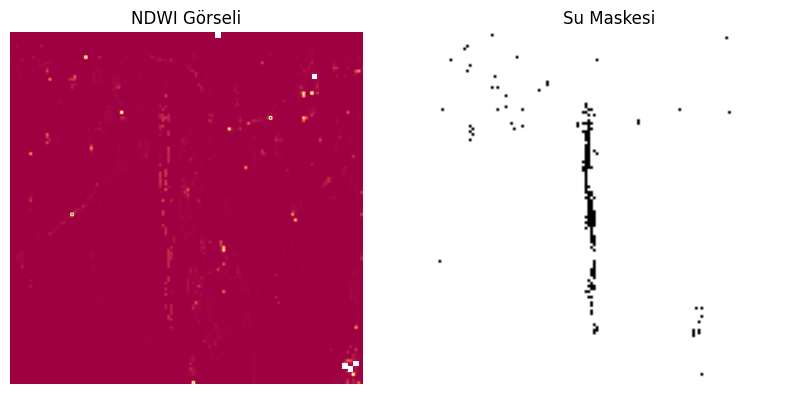

In [ ]:
def calculate_ndwi_rgb(image):
    green_band = image[:, :, 1]  # Yeşil bandı
    red_band = image[:, :, 0]    # Kırmızı bandı (NIR yerine)
    ndwi = (green_band - red_band) / (green_band + red_band)
    return ndwi

# Görselin NDWI hesaplaması
ndwi = calculate_ndwi_rgb(image_resized)

# Su tespiti için eşik belirleme
water_mask = ndwi > 0  # Su tespitini belirlemek için NDWI > 0 (su bulunur)

# Su maskesini görselleştirme
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("NDWI Görseli")
plt.imshow(ndwi, cmap="Spectral")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Su Maskesi")
plt.imshow(water_mask, cmap="gray")
plt.axis("off")
plt.show()